In [2]:
import numpy as np
import pandas as pd
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
import shap
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore", category=FutureWarning)

### DATA

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print("Number of train samples are",train.shape)
print("Number of test samples are",test.shape)
categorical_features = ['State_Factor', 'building_class', 'facility_type']
numerical_features=train.select_dtypes('number').columns

Number of train samples are (75757, 64)
Number of test samples are (9705, 63)


In [4]:
train.head()

Year_Factor State_Factor building_class  \
0            1      State_1     Commercial   
1            1      State_1     Commercial   
2            1      State_1     Commercial   
3            1      State_1     Commercial   
4            1      State_1     Commercial   

                               facility_type  floor_area  year_built  \
0               Grocery_store_or_food_market     61242.0      1942.0   
1  Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                       Retail_Enclosed_mall    280025.0      1951.0   
3                  Education_Other_classroom     55325.0      1980.0   
4                  Warehouse_Nonrefrigerated     66000.0      1985.0   

   energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  ...  \
0                11.0        2.4                36              50.5  ...   
1                45.0        1.8                36              50.5  ...   
2                97.0        1.8                36              50.5  ...   
3                46.0        1.8                36              50.5  ...   
4               100.0        2.4                36              50.5  ...   

   days_above_80F  days_above_90F  days_above_100F  days_above_110F  \
0              14               0                0                0   
1              14               0                0                0   
2              14               0                0                0   
3              14               0                0                0   
4              14               0                0                0   

   direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
0                       1.0                        1.0             1.0   
1                       1.0                        NaN             1.0   
2                       1.0                        NaN             1.0   
3                       1.0                        NaN             1.0   
4                       1.0                        1.0             1.0   

   days_with_fog    site_eui  id  
0            NaN  248.682615   0  
1           12.0   26.500150   1  
2           12.0   24.693619   2  
3           12.0   48.406926   3  
4            NaN    3.899395   4  

[5 rows x 64 columns]

### MISSING VALUE


Text(0.5, 1.0, 'Missing values in training Data')

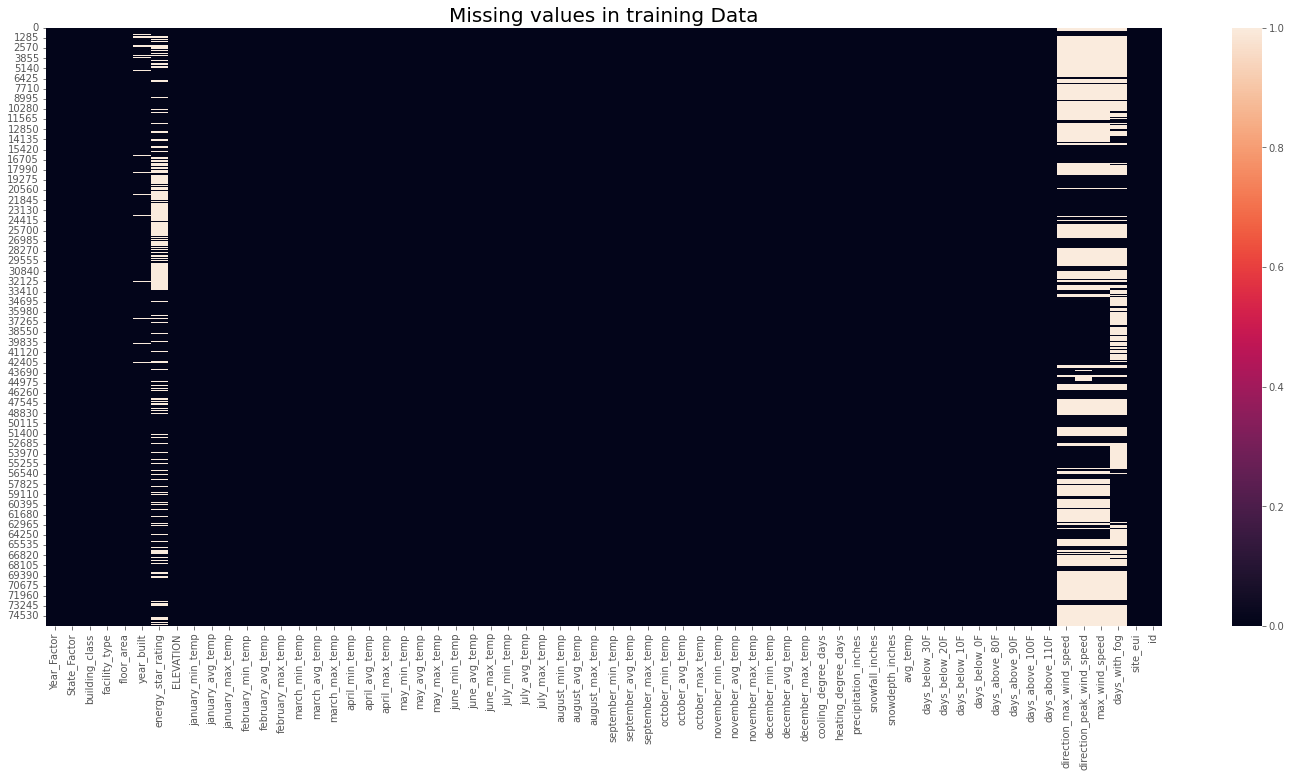

In [6]:
plt.figure(figsize = (25,11))
sns.heatmap(train.isna().values, xticklabels=train.columns)
plt.title("Missing values in training Data", size=20)

### MISSING VALUE IMPUTATION

In [7]:
missing_columns = [col for col in train.columns if train[col].isnull().any()]
missingvalues_count =train.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]
missingValues_df .style.background_gradient(cmap="Pastel1")

train['year_built'] =train['year_built'].replace(np.nan, 2022)
test['year_built'] =test['year_built'].replace(np.nan, 2022)
null_col=['energy_star_rating','direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog']
imputer = SimpleImputer()
imputer.fit(train[null_col])
data_transformed = imputer.transform(train[null_col])
train[null_col] = pd.DataFrame(data_transformed)
test_data_transformed = imputer.transform(test[null_col])
test[null_col] = pd.DataFrame(test_data_transformed)

Text(0.5, 1.0, 'Missing values in training Data')

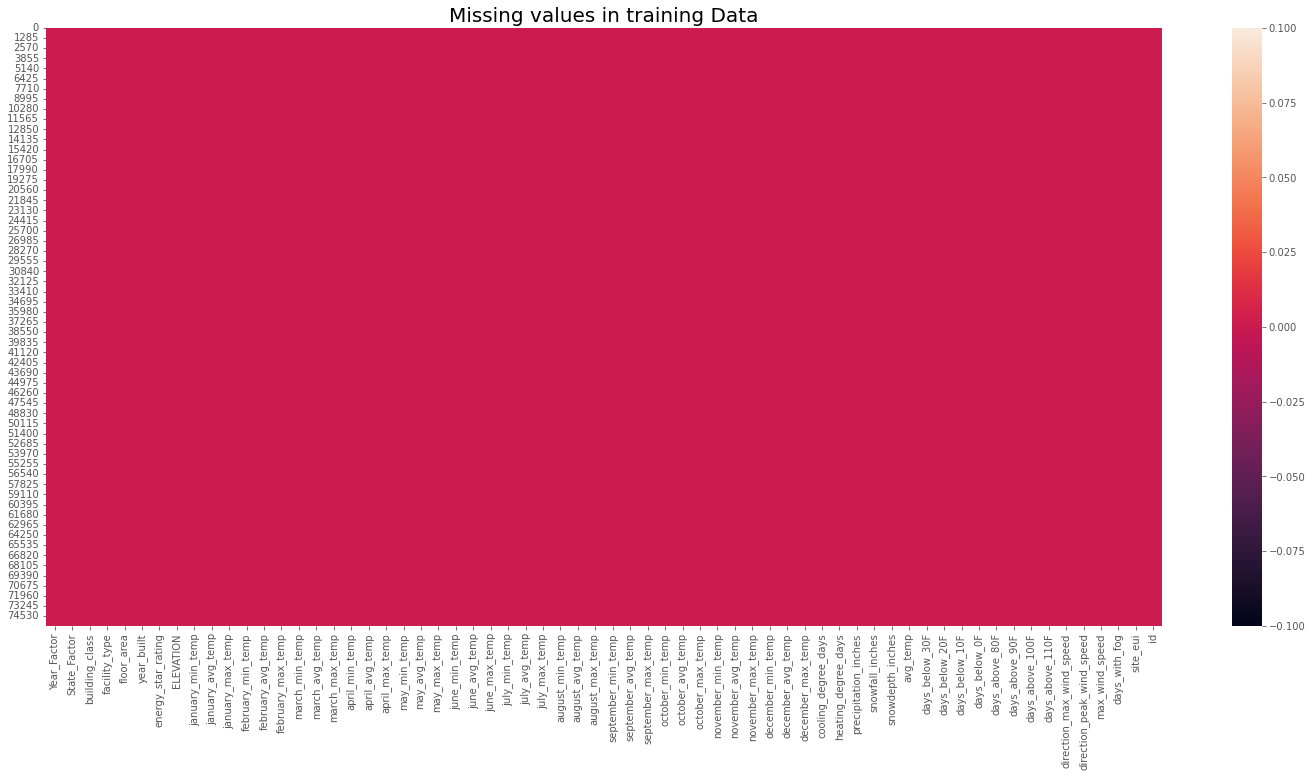

In [8]:
plt.figure(figsize = (25,11))
sns.heatmap(train.isna().values, xticklabels=train.columns)
plt.title("Missing values in training Data", size=20)

### LABEL ENCODING

In [9]:
le = LabelEncoder()
for col in categorical_features:
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])

In [10]:
train.head()


Year_Factor  State_Factor  building_class  facility_type  floor_area  \
0            1             0               0             13     61242.0   
1            1             0               0             55    274000.0   
2            1             0               0             48    280025.0   
3            1             0               0              6     55325.0   
4            1             0               0             56     66000.0   

   year_built  energy_star_rating  ELEVATION  january_min_temp  \
0      1942.0                11.0        2.4                36   
1      1955.0                45.0        1.8                36   
2      1951.0                97.0        1.8                36   
3      1980.0                46.0        1.8                36   
4      1985.0               100.0        2.4                36   

   january_avg_temp  ...  days_above_80F  days_above_90F  days_above_100F  \
0              50.5  ...              14               0                0   
1              50.5  ...              14               0                0   
2              50.5  ...              14               0                0   
3              50.5  ...              14               0                0   
4              50.5  ...              14               0                0   

   days_above_110F  direction_max_wind_speed  direction_peak_wind_speed  \
0                0                       1.0                   1.000000   
1                0                       1.0                  62.779974   
2                0                       1.0                  62.779974   
3                0                       1.0                  62.779974   
4                0                       1.0                   1.000000   

   max_wind_speed  days_with_fog    site_eui  id  
0             1.0     109.142051  248.682615   0  
1             1.0      12.000000   26.500150   1  
2             1.0      12.000000   24.693619   2  
3             1.0      12.000000   48.406926   3  
4             1.0     109.142051    3.899395   4  

[5 rows x 64 columns]

### FEATURE SCALING

In [11]:
train.describe().style.background_gradient()


In [12]:
import copy
y = train["site_eui"]
train = train.drop(["site_eui","id"],axis =1)
test = test.drop(["id"],axis =1)
trainnames = copy.deepcopy(train)
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [13]:
train

array([[-2.28876040e+00, -2.73502847e+00, -1.16308853e+00, ...,
        -7.08271499e-01, -7.30181542e-01,  4.45712541e-16],
       [-2.28876040e+00, -2.73502847e+00, -1.16308853e+00, ...,
        -8.14595953e-17, -7.30181542e-01, -3.04678581e+00],
       [-2.28876040e+00, -2.73502847e+00, -1.16308853e+00, ...,
        -8.14595953e-17, -7.30181542e-01, -3.04678581e+00],
       ...,
       [ 1.10929044e+00, -1.44431120e+00, -1.16308853e+00, ...,
        -8.14595953e-17,  4.06526186e-16,  4.45712541e-16],
       [ 1.10929044e+00, -1.44431120e+00, -1.16308853e+00, ...,
        -8.14595953e-17,  4.06526186e-16,  4.45712541e-16],
       [ 1.10929044e+00, -1.44431120e+00,  8.59779779e-01, ...,
        -8.14595953e-17,  4.06526186e-16,  4.45712541e-16]])

### MODEL:

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state = 50)

In [15]:
X_test_ft=pd.DataFrame(X_test,columns=trainnames.columns)

In [16]:
X_test_ft

Year_Factor  State_Factor  building_class  facility_type  floor_area  \
0          1.10929      0.491765       -1.163089      -1.711580   -0.322042   
1          1.10929      0.491765        0.859780       0.091718   -0.374352   
2          1.10929      0.491765        0.859780       0.091718   -0.438049   
3          0.42968     -0.153594       -1.163089      -1.110481   -0.449459   
4          0.42968     -0.798953        0.859780       0.091718    0.542852   
...            ...           ...             ...            ...         ...   
15147      0.42968     -1.444311       -1.163089      -2.055066   -0.565405   
15148     -0.24993     -0.798953       -1.163089      -1.711580   -0.323500   
15149     -0.24993      0.491765        0.859780       0.091718   -0.182100   
15150     -1.60915      0.491765        0.859780       0.091718   -0.402974   
15151      1.10929     -1.444311        0.859780      -2.226809   -0.001174   

       year_built  energy_star_rating  ELEVATION  january_min_temp  \
0        0.340944            1.255286  -0.595262         -0.046087   
1        1.363520            0.214685  -0.595262         -0.046087   
2       -0.340773           -2.126669  -0.249048         -0.046087   
3        0.760462           -0.132183   2.675632         -2.178064   
4       -0.366993            0.821702   0.077382         -0.365884   
...           ...                 ...        ...               ...   
15147    0.419604            0.000000  -0.349615          1.766093   
15148   -0.734071           -1.302859  -0.601856         -0.898878   
15149   -1.415788           -2.213385   0.052652         -0.792279   
15150   -0.629191            0.000000   0.052652          0.167110   
15151    0.314724            0.258043   4.508916          1.766093   

       january_avg_temp  ...  days_below_10F  days_below_0F  days_above_80F  \
0              0.020175  ...       -0.408211       0.042580        0.525662   
1              0.020175  ...       -0.408211       0.042580        0.525662   
2              0.020175  ...       -0.408211       0.042580        0.525662   
3             -1.987867  ...        4.258623       6.952893       -0.502707   
4             -0.620892  ...        1.288820      -0.302936        1.198058   
...                 ...  ...             ...            ...             ...   
15147          1.587877  ...       -0.691050      -0.302936       -1.689287   
15148         -0.860505  ...        1.005981      -0.302936        0.407004   
15149         -0.816701  ...        0.298885      -0.302936       -0.304943   
15150          0.430544  ...       -0.691050      -0.302936       -0.423601   
15151          1.306613  ...       -0.691050      -0.302936       -2.282577   

       days_above_90F  days_above_100F  days_above_110F  \
0            0.268761        -0.124112        -0.017181   
1            0.268761        -0.124112        -0.017181   
2            0.268761        -0.124112        -0.017181   
3           -0.919113        -0.124112        -0.017181   
4            0.725635        -0.124112        -0.017181   
...               ...              ...              ...   
15147       -1.101863        -0.124112        -0.017181   
15148        0.268761        -0.124112        -0.017181   
15149       -0.919113        -0.124112        -0.017181   
15150        0.268761        -0.124112        -0.017181   
15151       -1.010488        -0.124112        -0.017181   

       direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
0                     -0.738820              -7.082715e-01   -7.301815e-01   
1                     -0.738820              -7.082715e-01   -7.301815e-01   
2                      0.000000              -8.145960e-17    4.065262e-16   
3                      2.969218               3.178166e+00    3.023022e+00   
4                      0.000000              -8.145960e-17    4.065262e-16   
...                         ...                        ...             ...   
15147        

In [18]:
import xgboost
xgboost_model = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.02, gamma=0, subsample=0.75,
                           colsample_bytree=0.4, max_depth=5)
xgboost_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### 1.PERMUTATION IMPORTANCE USING ELI5 LIBRARY:

Permutation Importance is a method of understanding which features are of highest importance to our model.It ranks the features according to the weights in descending order of their importance.

The algorithm that Permutation Importance uses to get the insights is very interesting and novel.It's easy to understand and it overcomes the shortcomings of other feature importance methods.

1. First we train our model,here the xgboost model in our case on the train set.
2. Then we use the model as it is to get the predictions on our validation set.Then the rmse is calculated.
3. Further,the column whose feature importance has to be calculated is randomly shuffled.So,now our validation set is shuffled on 1 column.Then Step 2 is repeated on the shuffled validation set.The new rmse is compared to the old rmse and if there is an increase in the error,the feature importance is high,i.e. the shuffled feature was crucial in making predictions.It may also be possible that rmse decreases on shuffling or there is no change,then the shuffled feature is of nil importance to the model.The decrease in rmse after shuffling can be attributed to chance /luck or lower size of dataset that means higher probability of luck.
4. The validation set is then unshuffled to it's original state and the same steps are repeated for other features (one at a time) and then we obtain the feature importances.



In [20]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgboost_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = trainnames.columns.tolist(), top=63)

We can infer that on the global level ,the top features in the descending order of their importance are:**Energy Star Rating>Facility Type> Floor area**

### 2. SHAP 


SHAP — which stands for SHapley Additive exPlanations — is an algorithm was first published in 2017 by Lundberg and Lee and it is a brilliant way to reverse-engineer the output of any predictive algorithm. 


**WORKING**

We will see what the Shapley value is and how the SHAP (SHapley Additive exPlanations) value emerges from the Shapley concept.Understanding the idea behind the calculation of SHAP values is crucial to make sense of their outcome. We will go through the theoretical foundation of SHapley Additive exPlanations described in the article by Slundberg and Lee, and see why SHAP values are computed the way they are computed.

[This](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30) article provides a very great explanation of SHAP values calculation.


Important features of SHAP:
 * Global interpretability 
 * Local interpretability


In [21]:
explainer = shap.Explainer(xgboost_model)
shap_values = explainer(X_test_ft)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


###  GLOBAL INTERPRETABILITY

**Variable Importance Plot**

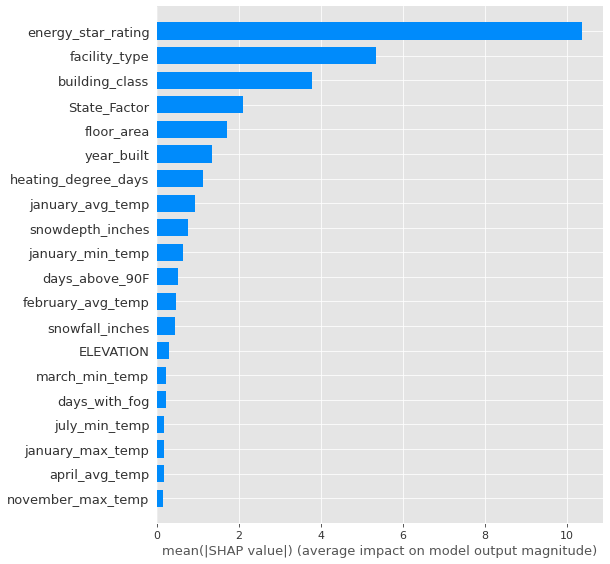

In [22]:
shap.summary_plot(shap_values, X_test_ft,plot_type="bar")

**INFERENCE:**

From this Variable Importance plot,we get similar results as the Permutation Importance.The features are arranged in descending order of their importance here.On the X-axis,we have the mean SHAP value for a feature.As the SHAP values are calculated per observation of the validation set ,to get a global interpretability across the dataset we need to have a mean of the calculated SHAP values.Here the positive or negative impact is not considered,just the magnitude of impact of a feature on the final predictions is taken into account.The below graph is also similar,just the impact is quantified by mentioning the mean(|SHAP|).

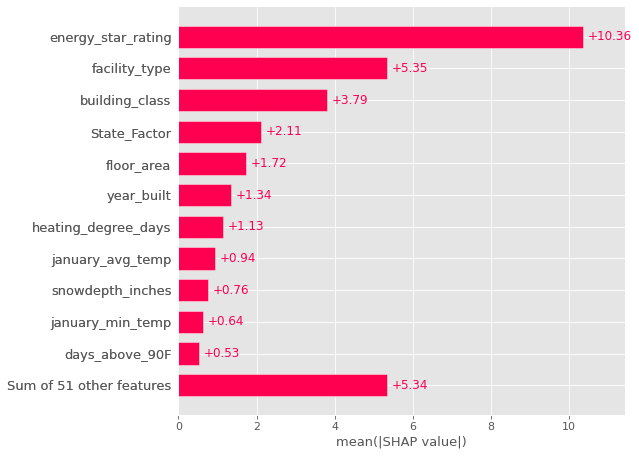

In [23]:
shap.plots.bar(shap_values,max_display=12)

**THE SUMMARY PLOT**:

The plot below shows the positive and negative relationship of a feature with the target variable prediction based on their SHAP values.Till now,we just saw the magnitude of the impact and not the nature of the impact.We'll see that now:


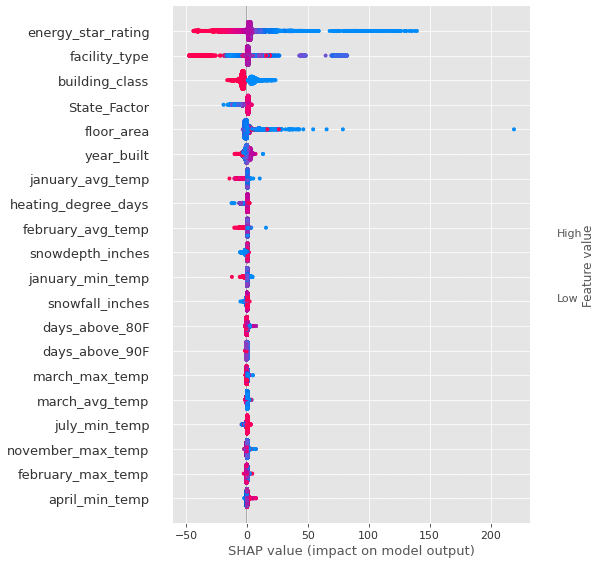

In [20]:
shap.summary_plot(shap_values, X_test_ft)


**INFERENCE:**

This plot is made of all the dots in the train data. It demonstrates the following information:

* **Feature importance**: Variables are ranked in descending order.
* **Impact**: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
* **Original value**: Color shows whether that variable is high (in red) or low (in blue) for that observation.
* **Correlation**: A low value of the “energy star rating”  has a high and positive impact on the building energy consumption. The “low” comes from the blue color, and the “positive” impact is shown on the X-axis(the horizontal location). Similarly, "building class" and "facility type" are also  negatively correlated with the target variable(site_eui_id).

**Interaction Plot**

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X_test_ft)
shap.summary_plot(shap_interaction_values, X_test_ft)

### LOCAL INTERPRETABILITY
**Waterfall Plot**

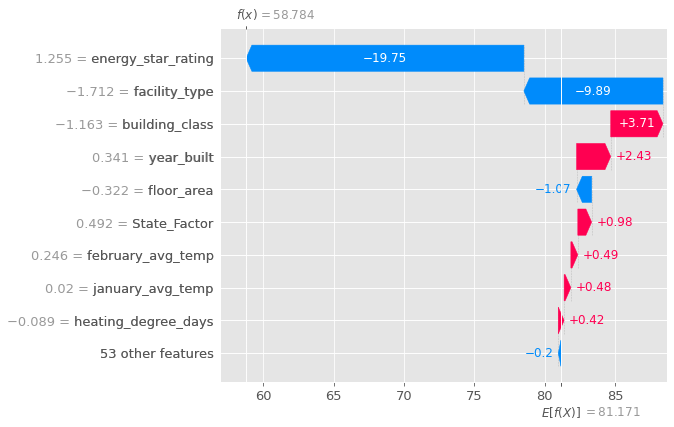

In [22]:
shap.plots.waterfall(shap_values[0])

The value at the bottom of the plot is E[f(X)] is the base value that is,“the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction, or mean(yhat),then we move upwards to see how much each feature is affecting the final prediction,f(X) for the given observation,either in the positive or negative direction.This gives a good local interpretation of the model's prediction.

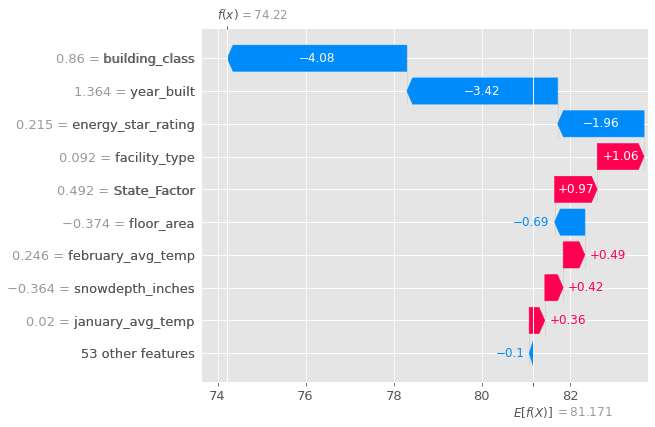

In [23]:
shap.plots.waterfall(shap_values[1])

**Force plot**

In [24]:
explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(X_test_ft)
shap.initjs()
def p(j):
    return(shap.force_plot(explainer.expected_value, shap_values[j,:], X_test_ft.iloc[j,:]))
p(0)

The plot looks beautiful,but what do we infer from this?

* **The output value**:In the above plot the number in bold ,i.e. 58.78 is the value our model predicted for the first observation in the validation set.
* **The base value**: The base value is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction, or mean(yhat).
* **Red/blue**: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.
* The values corresponding to the features are mentioned for the observation.

Energy Star Rating: has a negative impact on the building energy consumption. The energy_star rating value is 1.255 for this observation,which is higher than the average value in the train set. So it pushes the prediction to the left.
Similarly we can calculate for other features of the plot as well.


In [25]:
p(1)

**Decision Plot**

Used as an alternative for waterfall plot when the number of predictors is high,to get a non-clumsy plot.

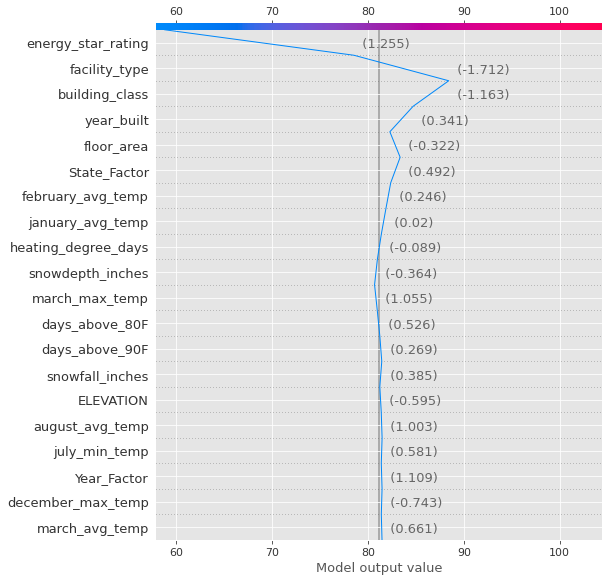

In [26]:
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X_test_ft)[0]
shap.decision_plot(expected_value, shap_values, X_test_ft)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


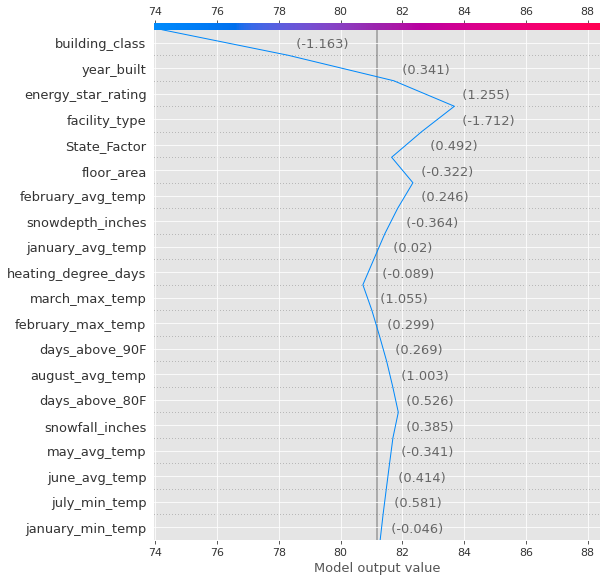

In [27]:
shap_values = explainer.shap_values(X_test_ft)[1]
shap.decision_plot(expected_value, shap_values, X_test_ft)

# 3.LIME:

Local Interpretable Model-Agnostic Explanations (LIME) can explain the predictions of any classifier in “an interpretable and faithful manner, by learning an interpretable model locally around the prediction”. Their approach is to gain the trust of users for individual predictions and then to trust the model as a whole.

One of the most important and novel feature of **LIME** is:

**LOCAL FIDELITY**:
The LIME model is all about interpreting local predictions in a faithful manner.The interpretation of a model's individual observation should correspond to atleast the points in it's vicinity.And,as you can see further how this is implemented in the LIME algorithm and how we can see this in the interpretation itself.
A model can be trained on 100s of features but while making a prediction for an individual observation,only a subset of those features play a key role and LIME provides us that insight.That is, the local interpretability.LIME,as the name suggests is concerned with local interpretation only.

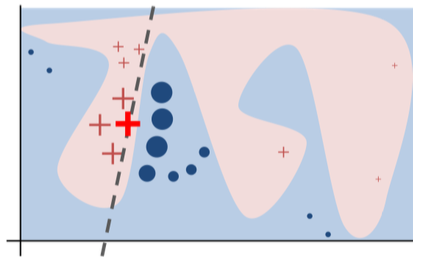

The graph above was provided by the authors of LIME.The graph gives an intuition into the working of LIME model.The original model we want to explain(xgboost in our example) is represented by the blue/pink background.The prediction we need to explain is the bold red cross in the image above.So,LIME:

1. Generates new samples in the vicinity of the red cross instance and then gets their predictions using the original model.
2. Weighting of the newly generated samples is done by the distance of the samples from the instance to be explained.
3. Finally,after getting the predictions for the newly generated samples including the red cross,a linear regression model is fitted,the black dashed line in the image above is the one used to explain our original model.This makes sure that the explanation is locally faithful as these explanations are generated from a linear regression model built taking the vicinity points +the original point into account.


In [28]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
                    feature_names=trainnames.columns, 
                    class_names=['site_eui'], 
                    categorical_features=categorical_features, 
                    verbose=True, mode='regression')

# LOCAL EXPLANATION

Intercept 94.92014107151691
Prediction_local [91.13043475]
Right: 58.784313


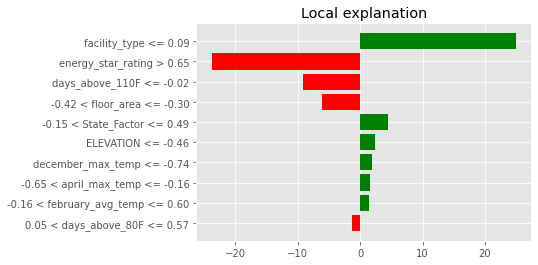

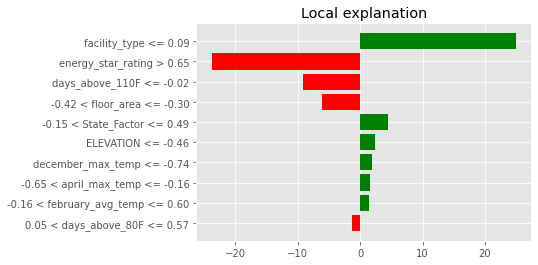

In [29]:
exp = explainer.explain_instance(X_test_ft.iloc[0], 
     xgboost_model.predict, num_features=10)
exp.as_pyplot_figure()

* Green/Red color: features that have positive correlations with the target are shown in green, otherwise red.
* Energy Star Rating>0.65:High energy star rating negatively correlate with high energy consumption.
* Facility Type<=0.09:Lower Facility Type positively correlate with high energy consumption.

We can understand the other features by using the same logic.


**Coefficients of the LIME model by as_list():**

In [30]:
pd.DataFrame(exp.as_list())


0          1
0              facility_type <= 0.09  24.975678
1          energy_star_rating > 0.65 -23.794272
2           days_above_110F <= -0.02  -9.213641
3        -0.42 < floor_area <= -0.30  -6.125573
4       -0.15 < State_Factor <= 0.49   4.514306
5                 ELEVATION <= -0.46   2.375223
6         december_max_temp <= -0.74   1.900143
7    -0.65 < april_max_temp <= -0.16   1.511992
8  -0.16 < february_avg_temp <= 0.60   1.404311
9      0.05 < days_above_80F <= 0.57  -1.337873

### RESULTS IN NOTEBOOK FORMAT:

In [31]:
exp.show_in_notebook(show_table=True, show_all=False)


In [32]:
exp = explainer.explain_instance(X_test_ft.iloc[1], xgboost_model.predict)
exp.show_in_notebook(show_table=True, show_all=False)

Intercept 79.40720440515193
Prediction_local [94.854192]
Right: 74.22026


* The LIME model intercept: 79.40720440515193
* The LIME model prediction: "Prediction_local [94.854192]"
* The original XGBOOST model prediction: "Right: 74.22026"

The local lime prediction =intercept+sum of coefficients

### ADVANTAGE OF LIME OVER SHAP:
We know that SHAP can give us local +global interpretability and LIME is just giving local interpretability,then why use LIME?It is important to note that the two algorithms are very different.The SHAP calculates the SHAP values for each feature first and to accomplish that it has to train models across all the possible feature combinations globally to get local interpretability.
But,the LIME algorithm is simpler and less time consuming when computing local interpretations.It does not go into global calculations in the process.So,the speed is an important factor.



### VALIDATION LOSS

In [33]:
from sklearn.metrics import explained_variance_score
predictions = xgboost_model.predict(X_test)
print(explained_variance_score(predictions,y_test))

-1.8933842759012331
